Group 4 Members

* Shyam Akhil Nekkanti - 8982123
* Jun He (Helena) - 8903073
* Zheming Li (Brendan) - 8914152

### Research Question

**What factors most strongly determine a video's likelihood of remaining on the youtube trending tab?**

*eg (views within first 24 hours of being placed in the trending tab, thumbnail image features, likes, dislikes, comment sentiments)*

After determining the relevant factors. 

**Can we predict the number of days a video will be shown on the trending tab?** (number of days between 1 - 30 )


### Dataset Description

**The dataset contains information about YouTube videos that have appeared in the trending tab in the US**. It includes various attributes:

- video title 
- channel title 
- publication date 
- trending date 
- views 
- likes 
- dislikes 
- comments
- tags

Each entry of a video indicates an instance or one day where the video appeared on the youtube trending list. 

In [3]:
# IMPORT REQUIRED LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from scipy.stats import shapiro, normaltest

In [4]:
# LOAD THE CATEGORIES JSON FILE AND CREATE A HASHMAP OF CATEGORY IDS

def load_category_mapping(json_file):
    with open(json_file, 'r') as f:
        category_data = json.load(f)
    formatted_categories = {int(item['id']): item['snippet']['title'] for item in category_data['items']}
    return formatted_categories

In [5]:
# READ THE YOUTUBE TRENDING VIDEO DATASET
def load_and_preprocess_data(csv_file, category_mapping):
    df = pd.read_csv(csv_file)
    
    # Convert dates
    df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
    df['publish_time'] = pd.to_datetime(df['publish_time'])
    
    # Add category names as a column using the hashmap we created.
    df['category_name'] = df['category_id'].map(category_mapping)
    
    # Calculate trending duration for each video
    trending_counts = df.groupby('video_id').size().reset_index(name='trending_duration')
    df = df.merge(trending_counts, on='video_id', how='left')

    # Create log-transformed columns for all the features we are considering
    numerical_cols = ['views', 'likes', 'dislikes', 'comment_count']
    for col in numerical_cols:
        df[f'log_{col}'] = np.log1p(df[col])
    
    # Add derived metrics
    df['likes_ratio'] = df['likes'] / (df['views'] + 1)
    df['dislikes_ratio'] = df['dislikes'] / (df['views'] + 1)
    df['comment_ratio'] = df['comment_count'] / (df['views'] + 1)
    return df

In [6]:
#Create plots for both original and log-transformed data for one metric

def plot_distribution_analysis(data, column, log_column, title):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'Distribution Analysis of {title}', fontsize=16)
    
    # Original data plots
    sns.histplot(data[column], kde=True, ax=axes[0,0])
    axes[0,0].set_title(f'Histogram of {title}')
    
    sns.boxplot(y=data[column], ax=axes[0,1])
    axes[0,1].set_title(f'Box Plot of {title}')
    
    stats.probplot(data[column], dist="norm", plot=axes[0,2])
    axes[0,2].set_title(f'Q-Q Plot of {title}')
    
    # Log-transformed plots
    sns.histplot(data[log_column], kde=True, ax=axes[1,0])
    axes[1,0].set_title(f'Histogram of Log {title}')
    
    sns.boxplot(y=data[log_column], ax=axes[1,1])
    axes[1,1].set_title(f'Box Plot of Log {title}')
    
    stats.probplot(data[log_column], dist="norm", plot=axes[1,2])
    axes[1,2].set_title(f'Q-Q Plot of Log {title}')
    
    plt.tight_layout()
    return fig

In [7]:
#Returns stats and Shapiro-Wilk test result of a metric (original and log-transformed metrics)
def analyze_metric(data, metric):
    log_metric = f'log_{metric}'
    
    subsample = data.sample(n=1000, random_state=42) #taking a subsample of 1000 entries for the Shapiro-Wilk test

    # Original data statistics
    orig_stats = data[metric].describe()
    orig_shapiro = shapiro(subsample[metric])
    
    # Log-transformed statistics
    log_stats = data[log_metric].describe()
    log_shapiro = shapiro(subsample[log_metric])
    
    return {
        'original': {
            'statistics': orig_stats,
            'shapiro_test': orig_shapiro,
        },
        'log_transformed': {
            'statistics': log_stats,
            'shapiro_test': log_shapiro,
        }
    }

In [13]:
# Load the csv dataset into a dataframe
category_mapping = load_category_mapping('youtube-dataset/US_category_id.json')
df = load_and_preprocess_data('youtube-dataset/USvideos.csv', category_mapping)
print(f"Loaded {len(df)} records")

print("\nDataset Overview:")
print(df.head(10))

      video_id trending_date  \
0  2kyS6SvSYSE    2017-11-14   
1  1ZAPwfrtAFY    2017-11-14   
2  5qpjK5DgCt4    2017-11-14   
3  puqaWrEC7tY    2017-11-14   
4  d380meD0W0M    2017-11-14   
5  gHZ1Qz0KiKM    2017-11-14   
6  39idVpFF7NQ    2017-11-14   
7  nc99ccSXST0    2017-11-14   
8  jr9QtXwC9vc    2017-11-14   
9  TUmyygCMMGA    2017-11-14   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   
5                              2 Weeks with iPhone X               iJustine   
6          Roy Moore & Jeff Sessions Cold Open - SNL    Saturday Night Live   
7              


Analysis for VIEWS

Original Data Statistics:
count    4.094900e+04
mean     2.360785e+06
std      7.394114e+06
min      5.490000e+02
25%      2.423290e+05
50%      6.818610e+05
75%      1.823157e+06
max      2.252119e+08
Name: views, dtype: float64
Shapiro-Wilk test: statistic=0.2974, p-value=0.0000e+00

Log-Transformed Data Statistics:
count    40949.000000
mean        13.337995
std          1.709989
min          6.309918
25%         12.398056
50%         13.432583
75%         14.416081
max         19.232552
Name: log_views, dtype: float64
Shapiro-Wilk test: statistic=0.9873, p-value=1.2877e-07

Analysis for LIKES

Original Data Statistics:
count    4.094900e+04
mean     7.426670e+04
std      2.288853e+05
min      0.000000e+00
25%      5.424000e+03
50%      1.809100e+04
75%      5.541700e+04
max      5.613827e+06
Name: likes, dtype: float64
Shapiro-Wilk test: statistic=0.3483, p-value=0.0000e+00

Log-Transformed Data Statistics:
count    40949.000000
mean         9.599392
std       

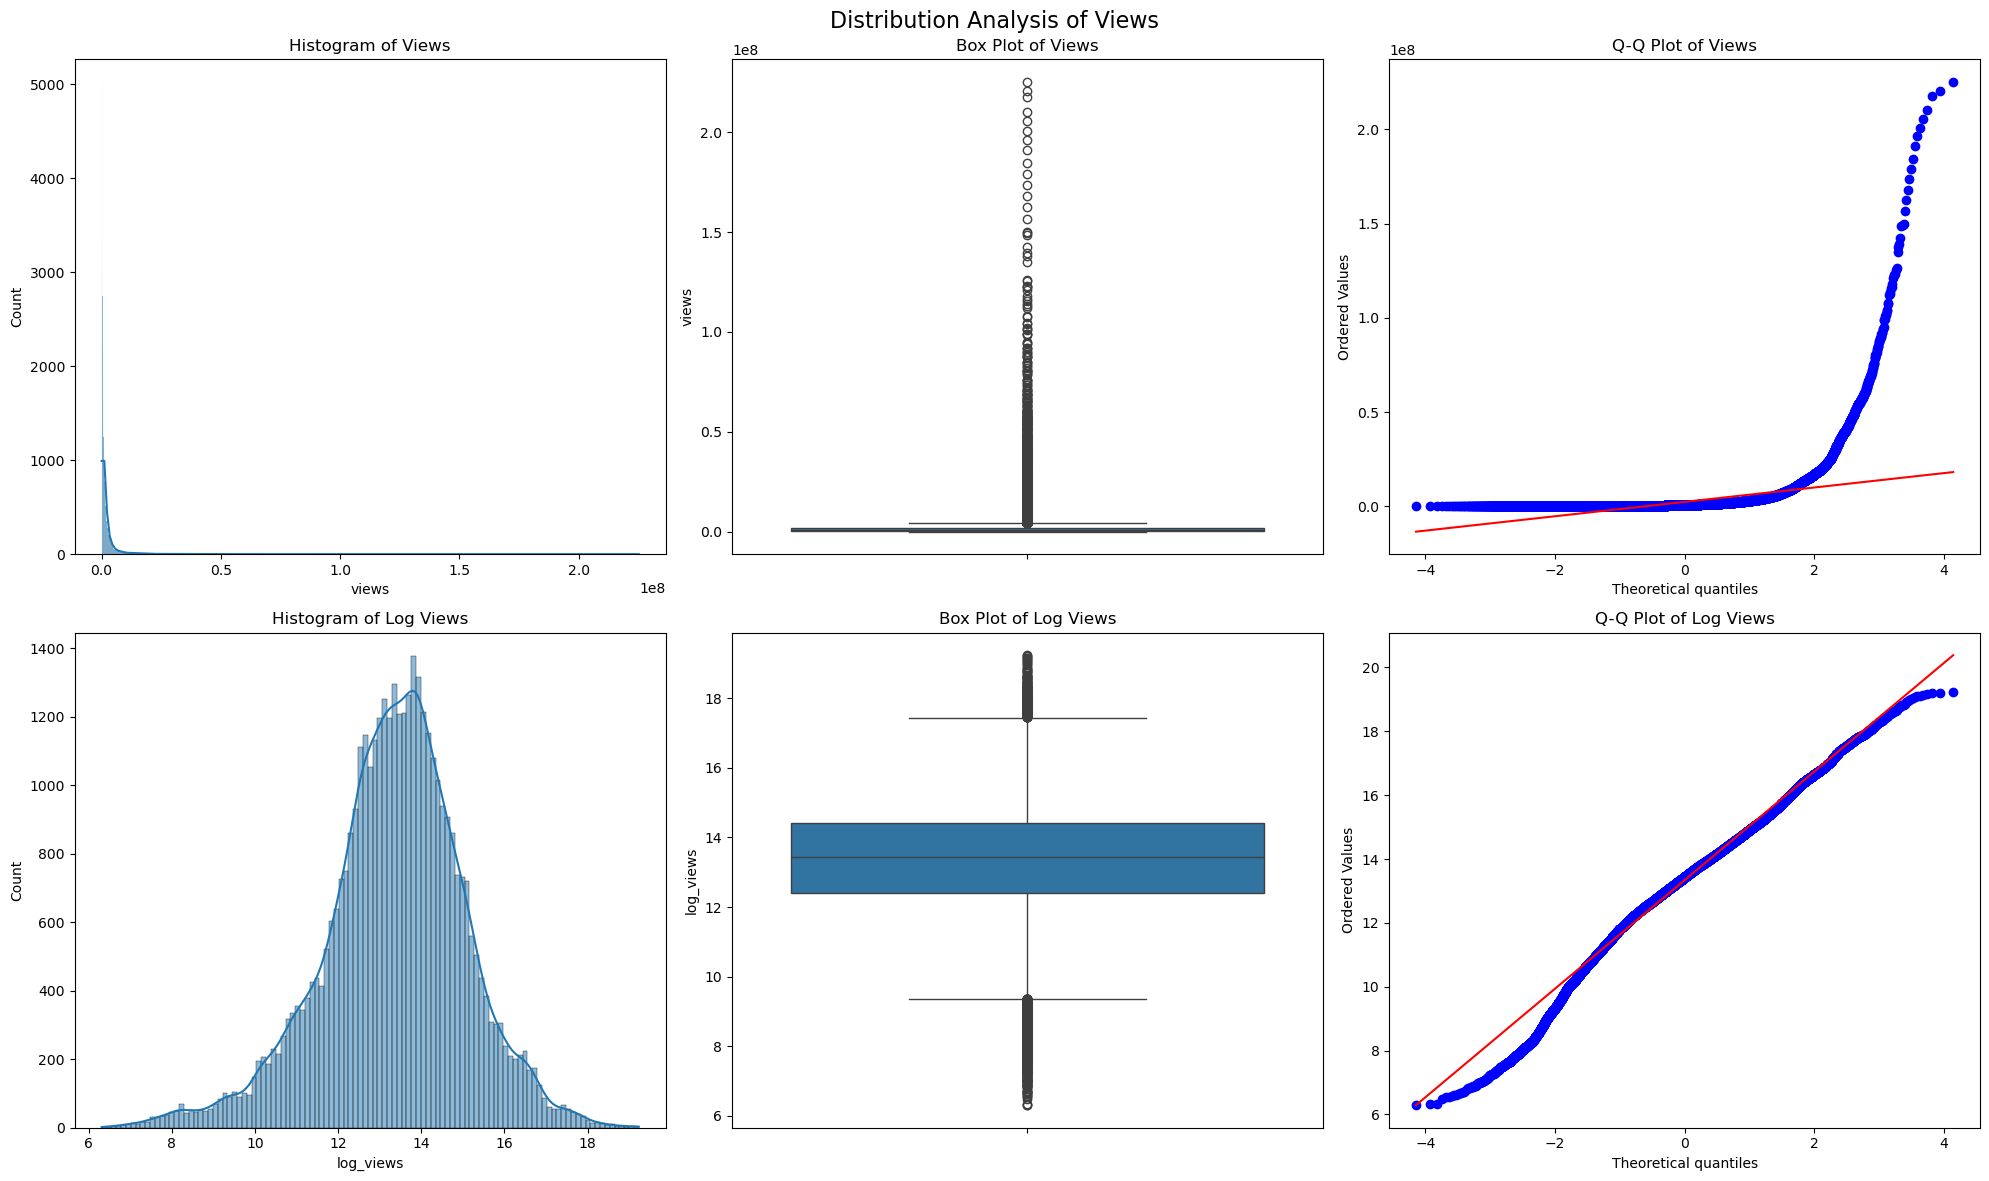

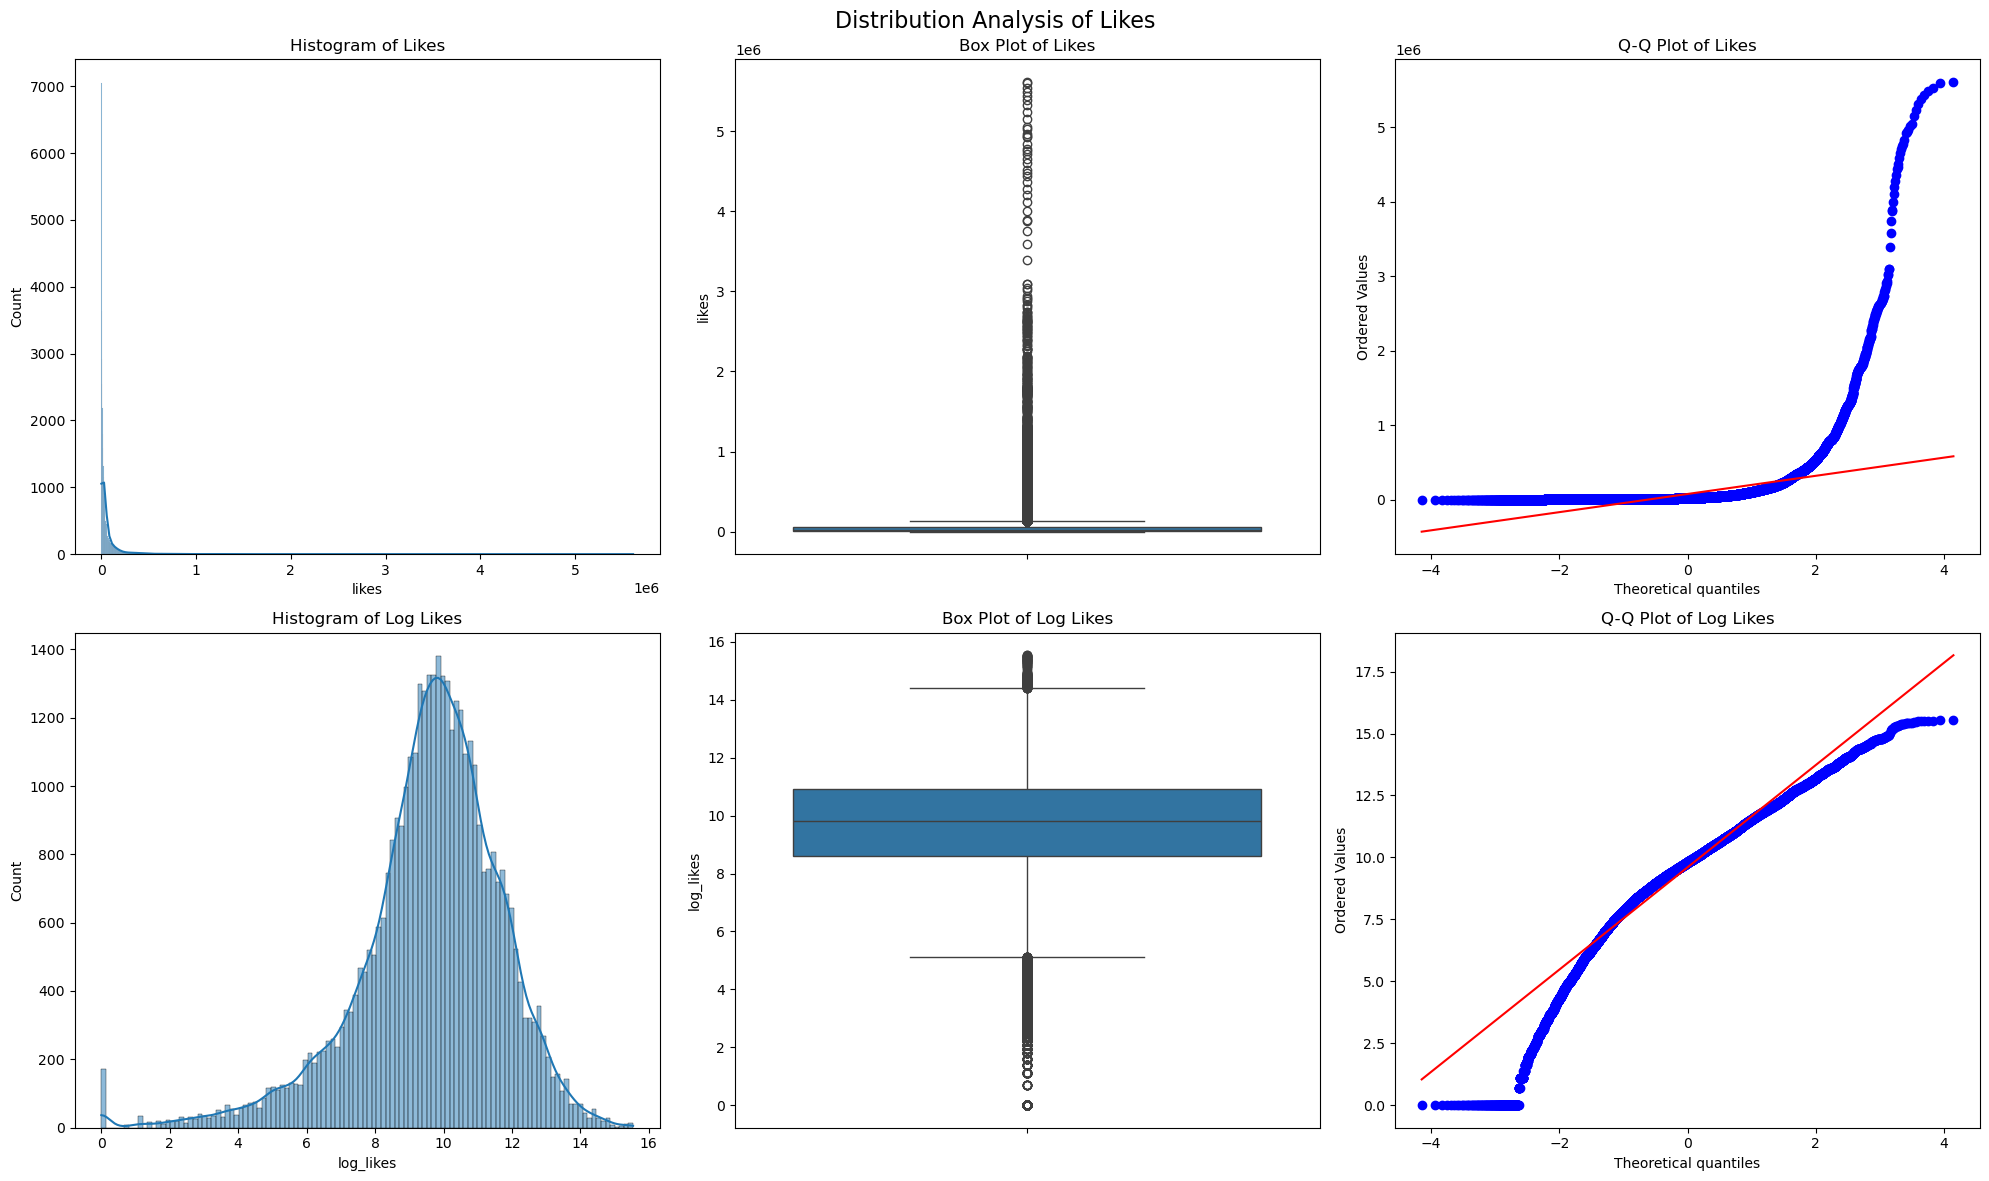

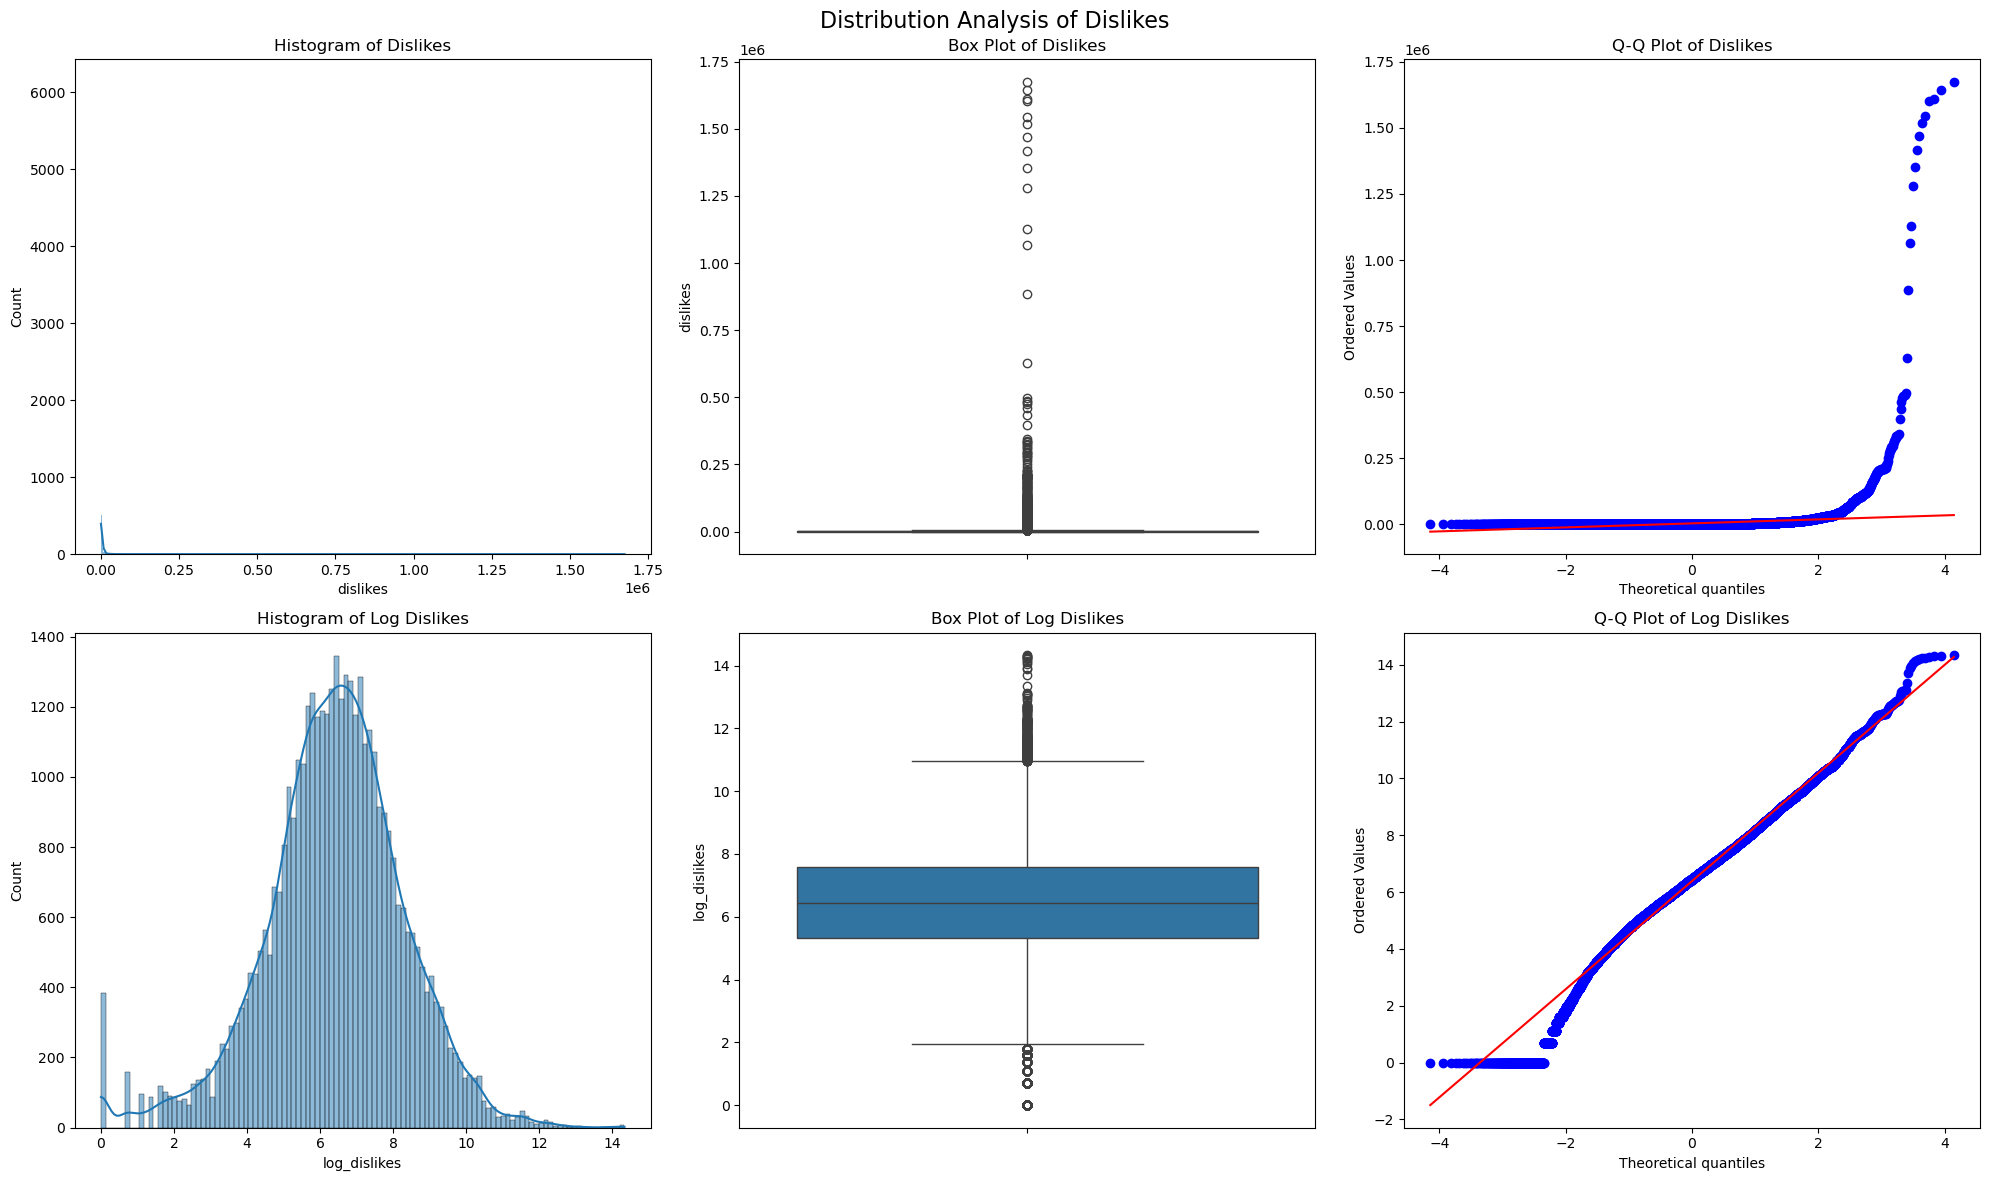

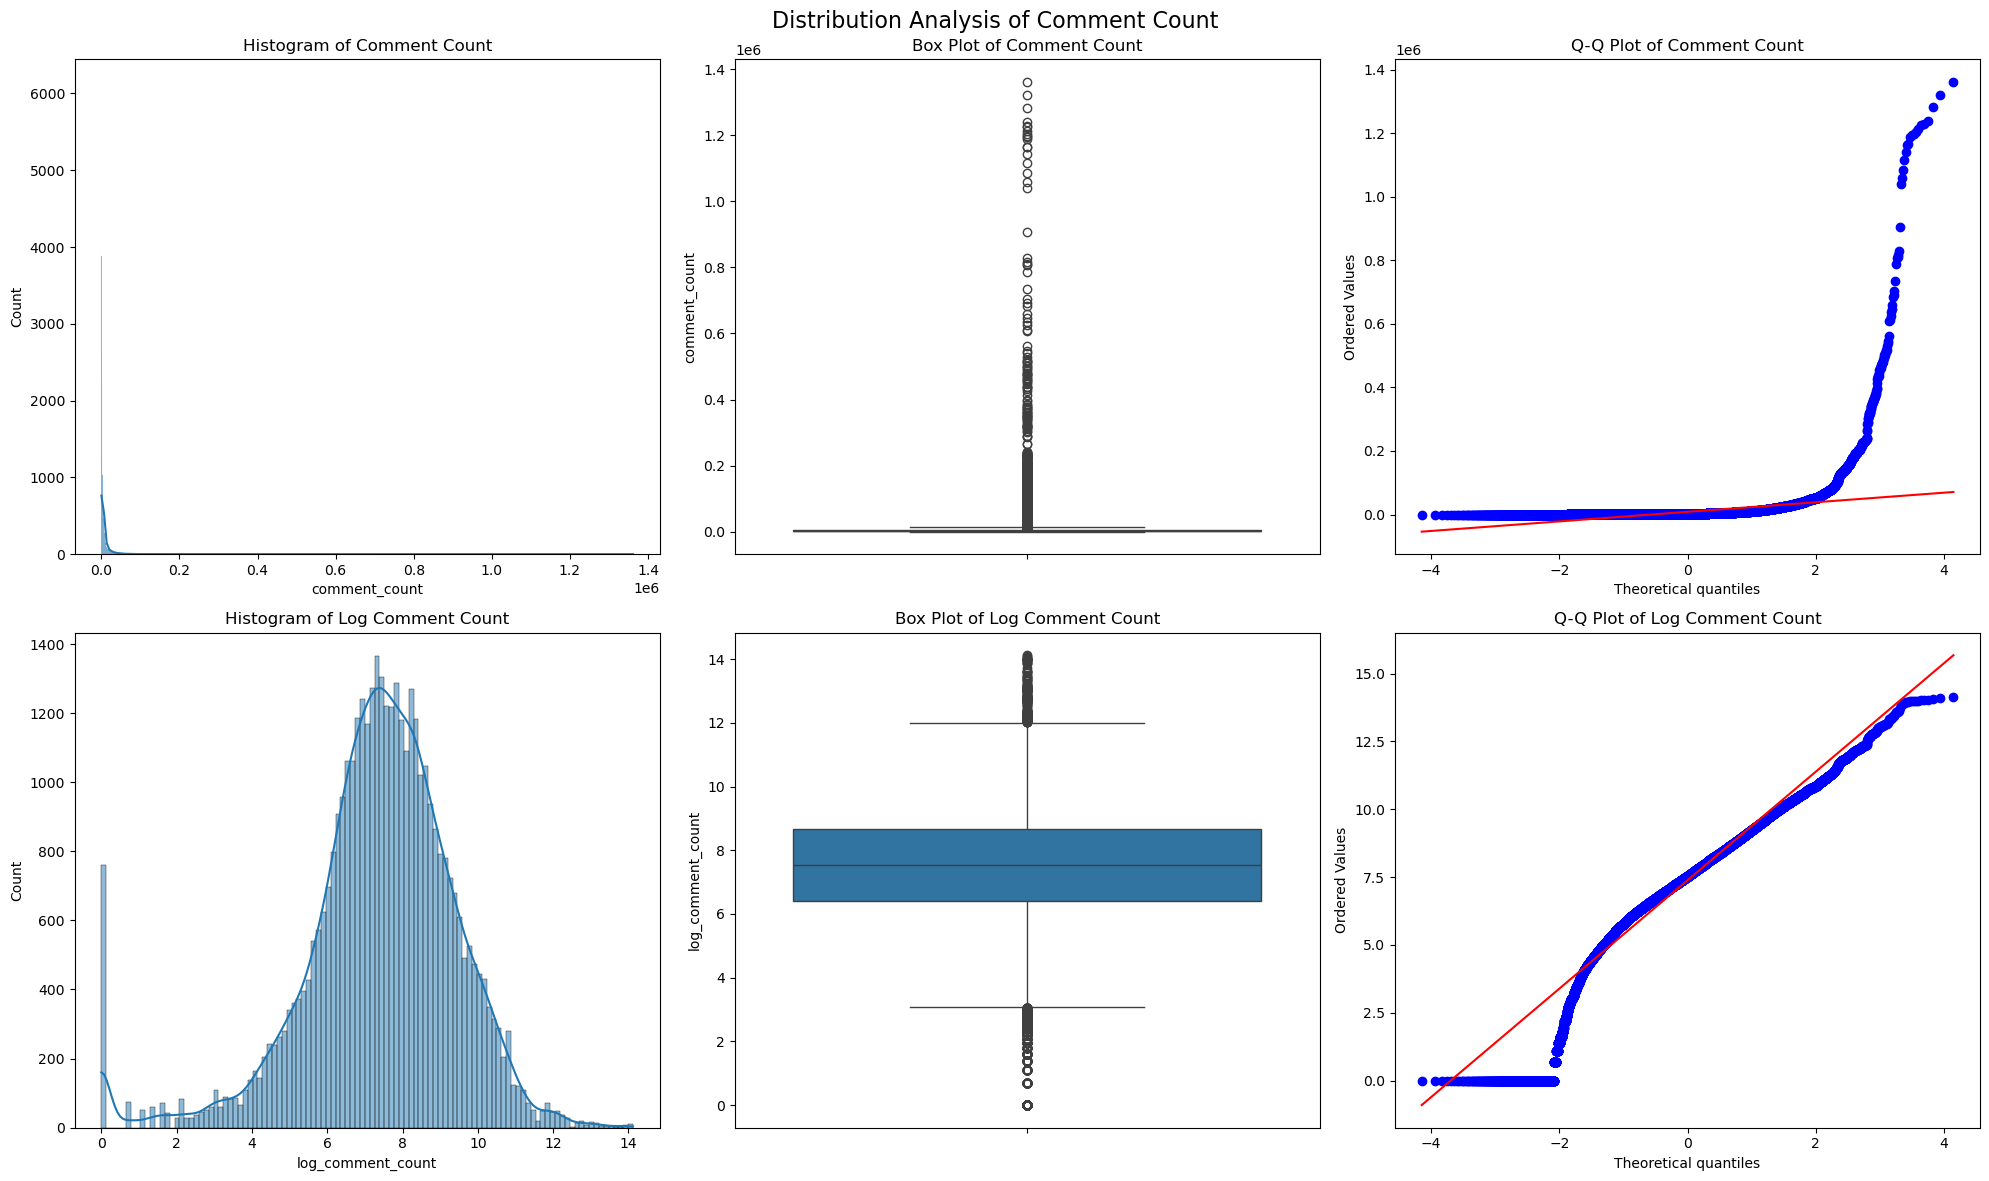

In [9]:
# The main features we are considering
metrics = ['views', 'likes', 'dislikes', 'comment_count']

for metric in metrics:
    print(f"\n{'='*50}")
    print(f"Analysis for {metric.upper()}")
    print(f"{'='*50}")
    
    # Create visualization
    fig = plot_distribution_analysis(df, metric, f'log_{metric}', metric.replace('_', ' ').title())
    
    # Perform analysis
    analysis_results = analyze_metric(df, metric)
    
    # Print results
    print("\nOriginal Data Statistics:")
    print(analysis_results['original']['statistics'])
    print(f"Shapiro-Wilk test: statistic={analysis_results['original']['shapiro_test'][0]:.4f}, p-value={analysis_results['original']['shapiro_test'][1]:.4e}")
    
    print("\nLog-Transformed Data Statistics:")
    print(analysis_results['log_transformed']['statistics'])
    print(f"Shapiro-Wilk test: statistic={analysis_results['log_transformed']['shapiro_test'][0]:.4f}, p-value={analysis_results['log_transformed']['shapiro_test'][1]:.4e}")


Correlation Analysis


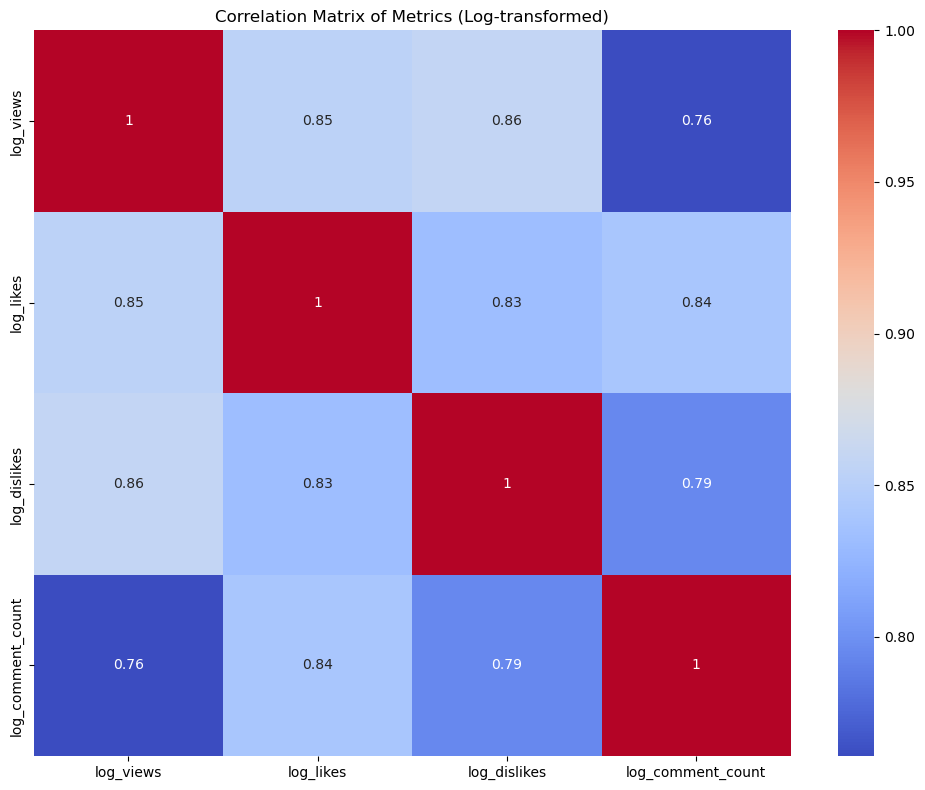

In [10]:
# Correlation Matrix
print("\nCorrelation Analysis")
print("="*50)
correlation_matrix = df[[f'log_{m}' for m in metrics]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Metrics (Log-transformed)')
plt.tight_layout()
plt.show()


Z-score Analysis (Log-transformed)

Views Log-transformed Z-score Summary:
count    4.094900e+04
mean     6.218919e-16
std      1.000012e+00
min     -4.110063e+00
25%     -5.496825e-01
50%      5.531513e-02
75%      6.304709e-01
max      3.447173e+00
Name: log_views_zscore, dtype: float64
Percentage of videos beyond 2 standard deviations: 5.32%


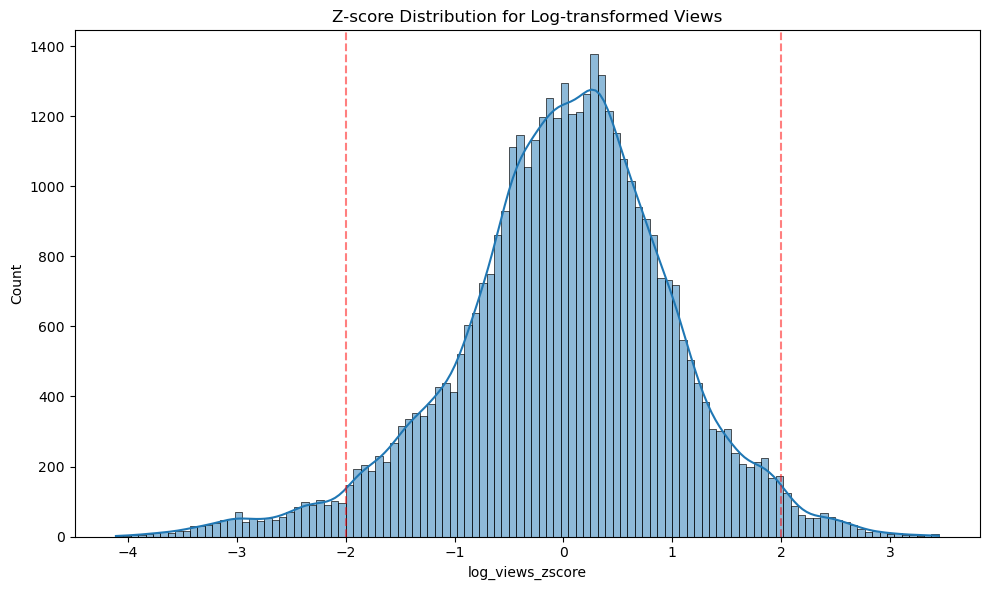


Likes Log-transformed Z-score Summary:
count    4.094900e+04
mean     2.221043e-17
std      1.000012e+00
min     -4.537220e+00
25%     -4.729496e-01
50%      9.634313e-02
75%      6.254518e-01
max      2.808222e+00
Name: log_likes_zscore, dtype: float64
Percentage of videos beyond 2 standard deviations: 5.00%


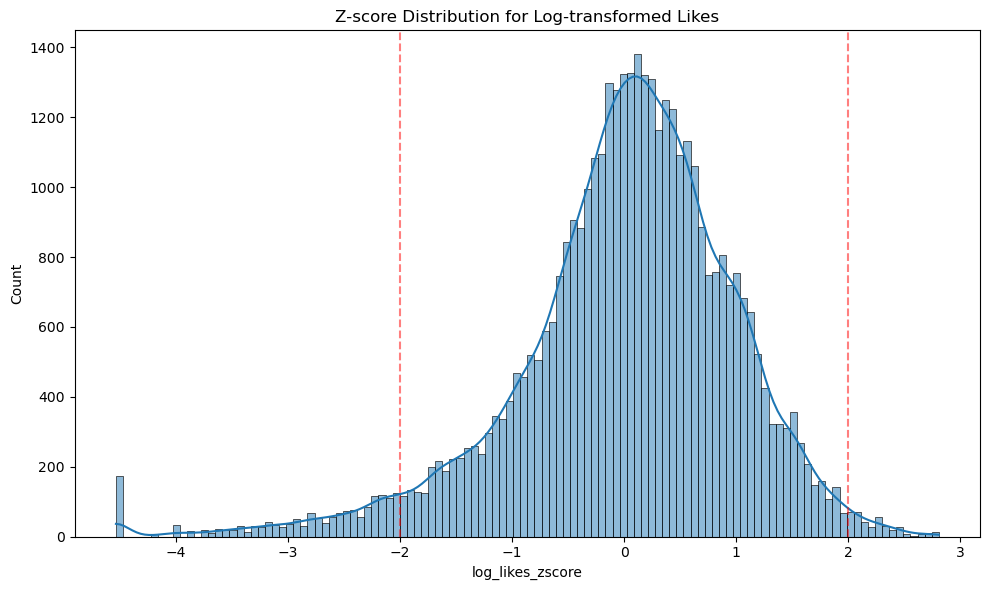


Dislikes Log-transformed Z-score Summary:
count    4.094900e+04
mean     1.776834e-16
std      1.000012e+00
min     -3.334593e+00
25%     -5.608829e-01
50%      3.199015e-02
75%      6.172178e-01
max      4.146762e+00
Name: log_dislikes_zscore, dtype: float64
Percentage of videos beyond 2 standard deviations: 5.33%


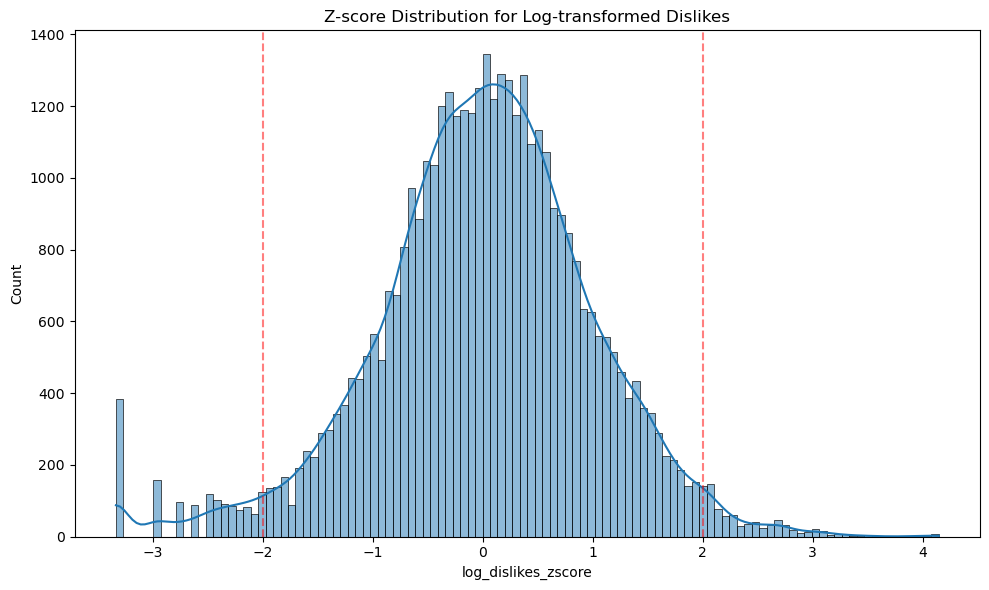


Comment_count Log-transformed Z-score Summary:
count    4.094900e+04
mean    -1.665782e-16
std      1.000012e+00
min     -3.591367e+00
25%     -4.696423e-01
50%      6.757441e-02
75%      6.175205e-01
max      3.274768e+00
Name: log_comment_count_zscore, dtype: float64
Percentage of videos beyond 2 standard deviations: 4.97%


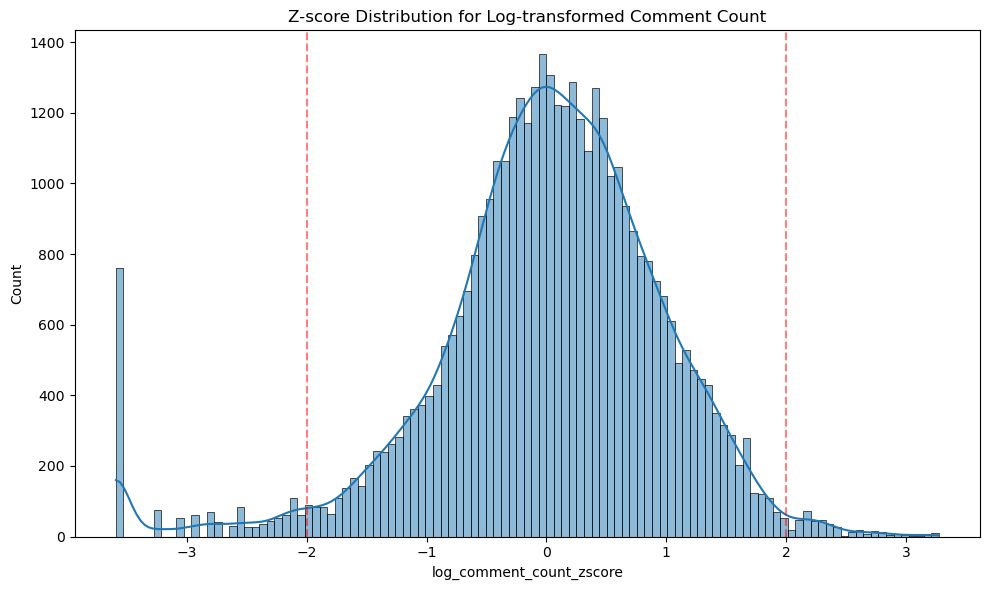

In [11]:
# Z-score using log-transformed metrics
print("\nZ-score Analysis (Log-transformed)")
print("="*50)

for metric in metrics:
    log_metric = f'log_{metric}'
    
    # Calculate Z-scores using log-transformed data
    df[f'{log_metric}_zscore'] = stats.zscore(df[log_metric])
    
    # Print Z-score summary statistics
    print(f"\n{metric.capitalize()} Log-transformed Z-score Summary:")
    print(df[f'{log_metric}_zscore'].describe())
    
    # Calculate and print percentage of videos beyond 2 standard deviations
    outliers = np.abs(df[f'{log_metric}_zscore']) > 2
    outlier_percentage = (outliers.sum() / len(df)) * 100
    print(f"Percentage of videos beyond 2 standard deviations: {outlier_percentage:.2f}%")
    
    # Create Z-score distribution plot
    plt.figure(figsize=(10, 6))
    sns.histplot(df[f'{log_metric}_zscore'], kde=True)
    plt.title(f'Z-score Distribution for Log-transformed {metric.replace("_", " ").title()}')
    plt.axvline(x=2, color='r', linestyle='--', alpha=0.5)
    plt.axvline(x=-2, color='r', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


T-score Analysis by Category (Log-transformed)

Views Log-transformed T-scores by category:
Autos & Vehicles:
  Log Mean: 12.73
  T-score: -6.72
  p-value: 0.0000
Comedy:
  Log Mean: 13.53
  T-score: 8.55
  p-value: 0.0000
Education:
  Log Mean: 12.92
  T-score: -14.80
  p-value: 0.0000
Entertainment:
  Log Mean: 13.37
  T-score: 1.98
  p-value: 0.0476
Film & Animation:
  Log Mean: 13.72
  T-score: 10.11
  p-value: 0.0000
Gaming:
  Log Mean: 13.97
  T-score: 11.50
  p-value: 0.0000
Howto & Style:
  Log Mean: 13.03
  T-score: -14.72
  p-value: 0.0000
Music:
  Log Mean: 14.12
  T-score: 33.46
  p-value: 0.0000
News & Politics:
  Log Mean: 12.08
  T-score: -34.32
  p-value: 0.0000
Nonprofits & Activism:
  Log Mean: 11.48
  T-score: -4.99
  p-value: 0.0000
People & Blogs:
  Log Mean: 13.20
  T-score: -5.04
  p-value: 0.0000
Pets & Animals:
  Log Mean: 12.86
  T-score: -10.36
  p-value: 0.0000
Science & Technology:
  Log Mean: 13.10
  T-score: -6.86
  p-value: 0.0000
Shows:
  Log Mean: 13.

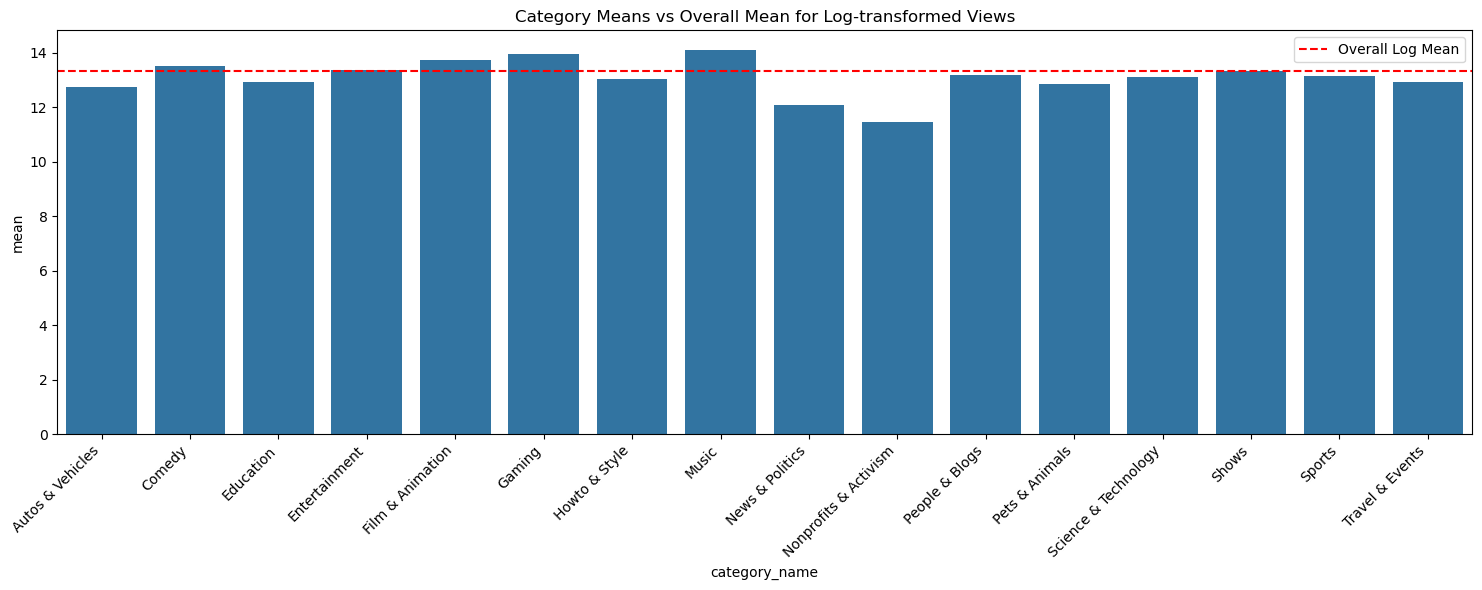


Likes Log-transformed T-scores by category:
Autos & Vehicles:
  Log Mean: 7.89
  T-score: -13.64
  p-value: 0.0000
Comedy:
  Log Mean: 10.15
  T-score: 20.27
  p-value: 0.0000
Education:
  Log Mean: 9.47
  T-score: -3.46
  p-value: 0.0006
Entertainment:
  Log Mean: 9.44
  T-score: -7.88
  p-value: 0.0000
Film & Animation:
  Log Mean: 9.71
  T-score: 2.39
  p-value: 0.0171
Gaming:
  Log Mean: 10.54
  T-score: 15.57
  p-value: 0.0000
Howto & Style:
  Log Mean: 9.78
  T-score: 7.82
  p-value: 0.0000
Music:
  Log Mean: 10.81
  T-score: 47.24
  p-value: 0.0000
News & Politics:
  Log Mean: 7.39
  T-score: -54.99
  p-value: 0.0000
Nonprofits & Activism:
  Log Mean: 7.59
  T-score: -3.86
  p-value: 0.0003
People & Blogs:
  Log Mean: 9.61
  T-score: 0.40
  p-value: 0.6924
Pets & Animals:
  Log Mean: 9.28
  T-score: -6.79
  p-value: 0.0000
Science & Technology:
  Log Mean: 9.31
  T-score: -7.09
  p-value: 0.0000
Shows:
  Log Mean: 9.50
  T-score: -0.71
  p-value: 0.4822
Sports:
  Log Mean: 8.58

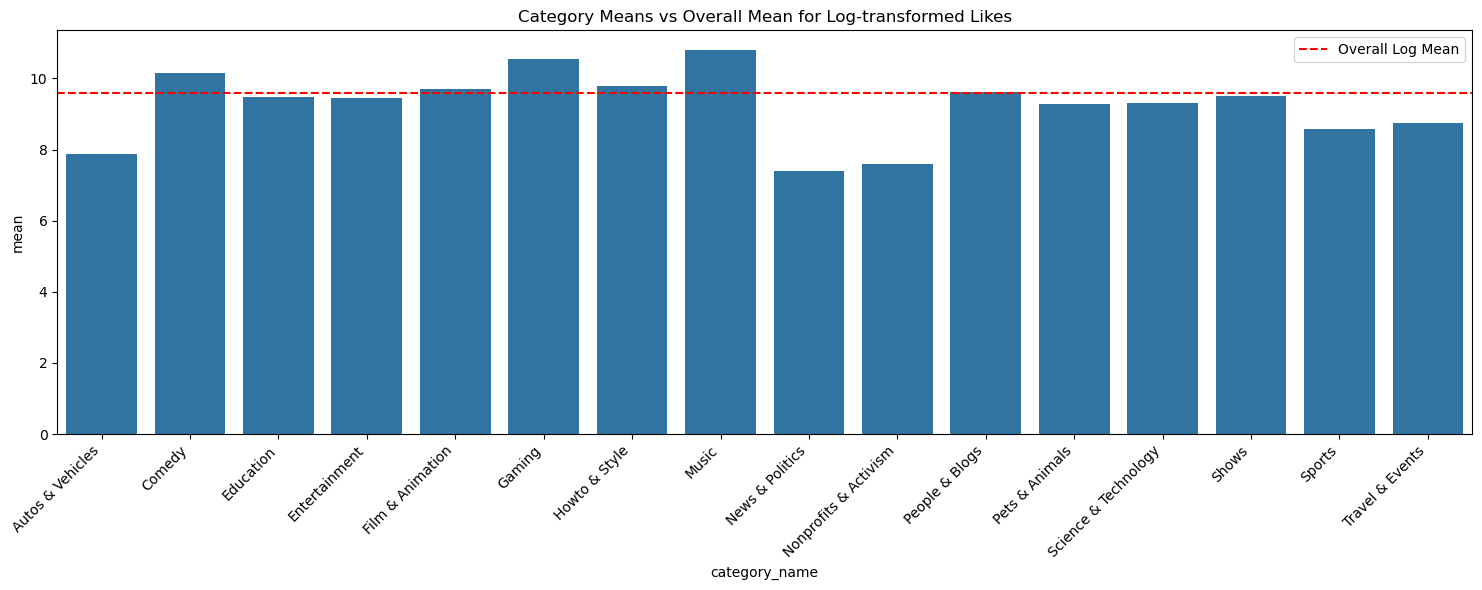


Dislikes Log-transformed T-scores by category:
Autos & Vehicles:
  Log Mean: 5.22
  T-score: -11.60
  p-value: 0.0000
Comedy:
  Log Mean: 6.71
  T-score: 12.41
  p-value: 0.0000
Education:
  Log Mean: 5.93
  T-score: -12.94
  p-value: 0.0000
Entertainment:
  Log Mean: 6.39
  T-score: 0.21
  p-value: 0.8356
Film & Animation:
  Log Mean: 6.57
  T-score: 4.39
  p-value: 0.0000
Gaming:
  Log Mean: 7.45
  T-score: 14.88
  p-value: 0.0000
Howto & Style:
  Log Mean: 6.18
  T-score: -8.82
  p-value: 0.0000
Music:
  Log Mean: 7.13
  T-score: 29.06
  p-value: 0.0000
News & Politics:
  Log Mean: 5.70
  T-score: -17.51
  p-value: 0.0000
Nonprofits & Activism:
  Log Mean: 4.91
  T-score: -2.82
  p-value: 0.0067
People & Blogs:
  Log Mean: 6.24
  T-score: -4.11
  p-value: 0.0000
Pets & Animals:
  Log Mean: 5.49
  T-score: -17.82
  p-value: 0.0000
Science & Technology:
  Log Mean: 6.13
  T-score: -6.32
  p-value: 0.0000
Shows:
  Log Mean: 5.94
  T-score: -5.88
  p-value: 0.0000
Sports:
  Log Mean: 5

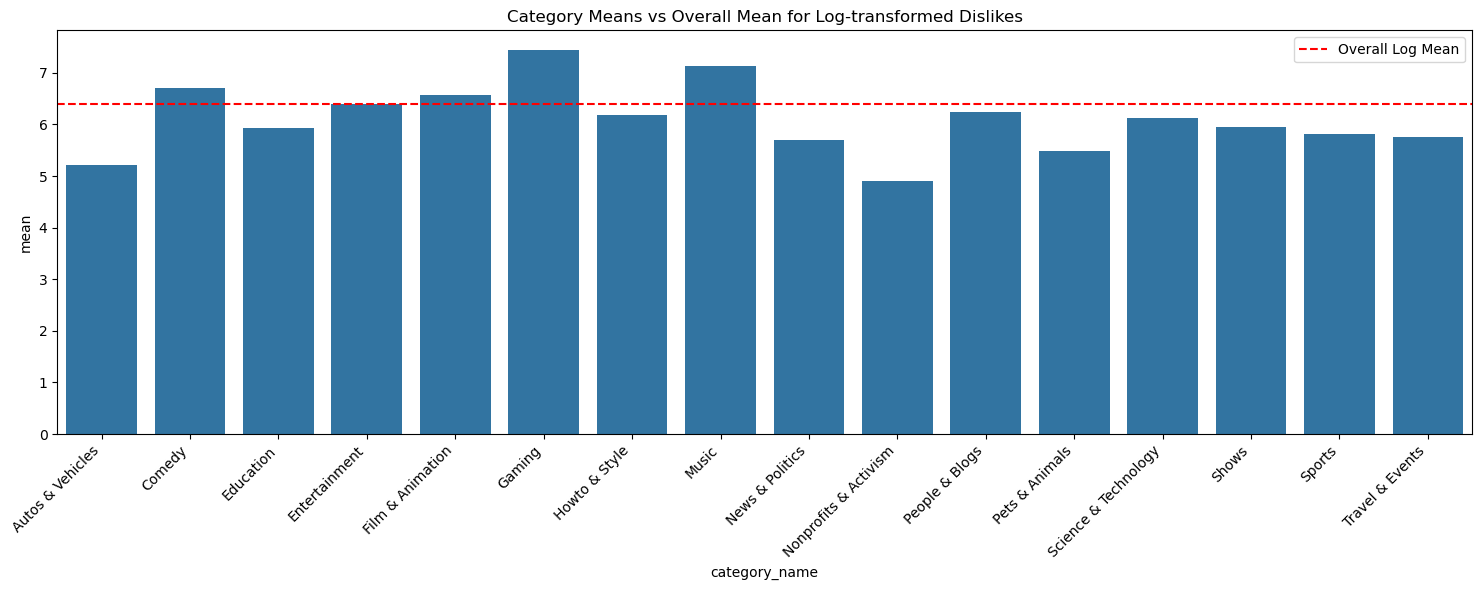


Comment_count Log-transformed T-scores by category:
Autos & Vehicles:
  Log Mean: 6.31
  T-score: -9.74
  p-value: 0.0000
Comedy:
  Log Mean: 7.77
  T-score: 13.58
  p-value: 0.0000
Education:
  Log Mean: 7.30
  T-score: -2.46
  p-value: 0.0139
Entertainment:
  Log Mean: 7.22
  T-score: -8.13
  p-value: 0.0000
Film & Animation:
  Log Mean: 7.51
  T-score: 2.71
  p-value: 0.0069
Gaming:
  Log Mean: 8.68
  T-score: 18.58
  p-value: 0.0000
Howto & Style:
  Log Mean: 7.47
  T-score: 3.41
  p-value: 0.0007
Music:
  Log Mean: 8.18
  T-score: 32.66
  p-value: 0.0000
News & Politics:
  Log Mean: 6.19
  T-score: -24.72
  p-value: 0.0000
Nonprofits & Activism:
  Log Mean: 5.76
  T-score: -3.15
  p-value: 0.0027
People & Blogs:
  Log Mean: 7.32
  T-score: -1.85
  p-value: 0.0641
Pets & Animals:
  Log Mean: 7.00
  T-score: -7.26
  p-value: 0.0000
Science & Technology:
  Log Mean: 7.03
  T-score: -7.65
  p-value: 0.0000
Shows:
  Log Mean: 7.32
  T-score: -0.91
  p-value: 0.3687
Sports:
  Log Mean:

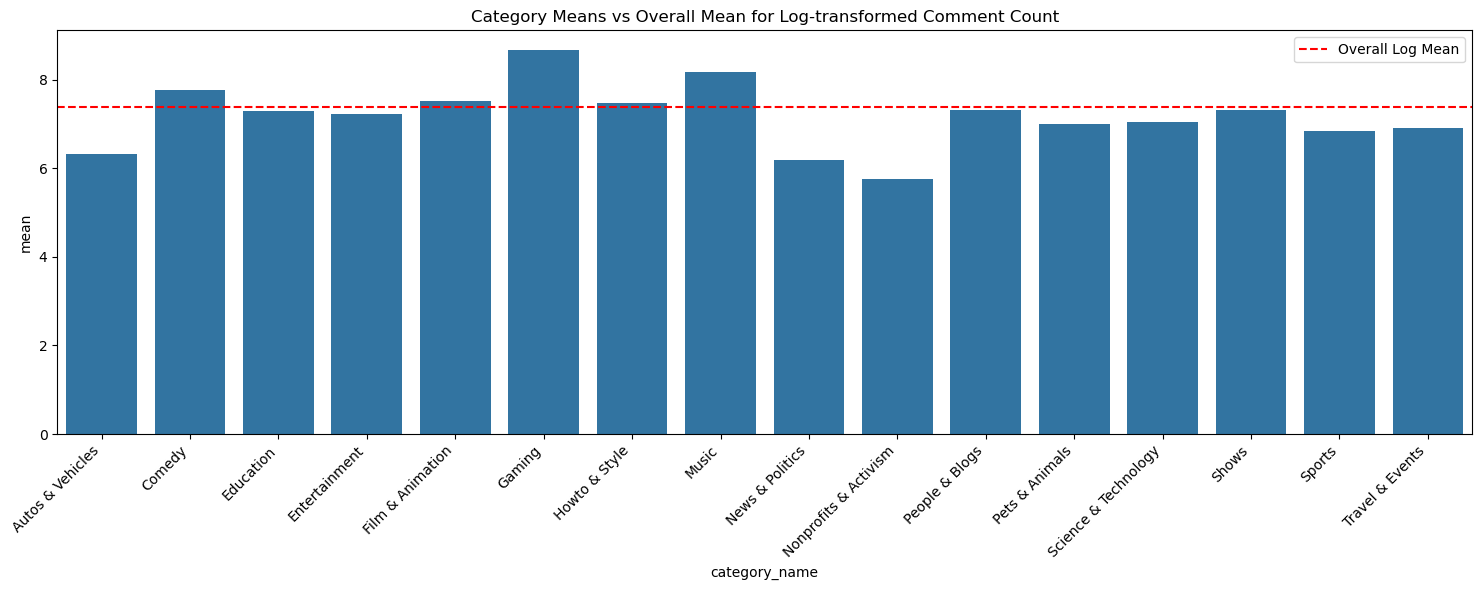

In [12]:
# T-score using log-transformed metrics
print("\nT-score Analysis by Category (Log-transformed)")
print("="*50)

for metric in metrics:
    log_metric = f'log_{metric}'
    print(f"\n{metric.capitalize()} Log-transformed T-scores by category:")
    overall_log_mean = df[log_metric].mean()
    
    # Calculate T-scores for each category using log-transformed data
    category_stats = df.groupby('category_name').agg({
        log_metric: ['mean', 'count', 'std']
    }).reset_index()
    
    category_stats.columns = ['category_name', 'mean', 'count', 'std']
    
    for _, row in category_stats.iterrows():
        category = row['category_name']
        category_log_data = df[df['category_name'] == category][log_metric]
        
        # Perform one-sample t-test on log-transformed data
        t_stat, p_value = stats.ttest_1samp(category_log_data, overall_log_mean)
        
        print(f"{category}:")
        print(f"  Log Mean: {row['mean']:.2f}")
        print(f"  T-score: {t_stat:.2f}")
        print(f"  p-value: {p_value:.4f}")
    
    # Visualize category means compared to overall mean
    plt.figure(figsize=(15, 6))
    sns.barplot(x='category_name', y='mean', data=category_stats)
    plt.axhline(y=overall_log_mean, color='r', linestyle='--', label='Overall Log Mean')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Category Means vs Overall Mean for Log-transformed {metric.replace("_", " ").title()}')
    plt.legend()
    plt.tight_layout()
    plt.show()

**Z Score**
The mean Z-score is approximately zero, and the standard deviation is one. This is expected for normalized distributions.

The histogram shows a bell-shaped curve, with most videos clustering around the mean.
Approximately 5.32% of videos have Z-scores beyond 2 standard deviations and can be considered outliers.

**Key Takeaways**

High-Performing Categories: 
- Music
- Gaming
- Film & Animation
these categories tend to have higher average views.

Low-Performing Categories: 
- News & Politics, 
- Education
- Howto & Style
these categories tend to have lower average views.

**T Score**
The T scores provide insights into how different video categories perform relative to the overall mean.

*video containing a video category* - sample 
*all videos* - population

for example taking the T-scores for views,

**Categories with Positive T-scores:**
- Entertainment  1.98
- Comedy  8.55
- Film & Animation  10.11
- Gaming: T-score  11.50
- Music: T-score  33.46

**Categories with Negative T-scores**
- Autos & Vehicles  -6.72
- Education  -14.80
- Howto & Style  -14.72
- News & Politics  -34.32

We can observe there is a hierarchy in categories within the trending tab for all the metrics, 
with almost all categories showing significant differences from the mean.